## Comparing signature quality with signature similarity
### For PROGENy benchmark

In [20]:
from subprocess import call

In [ ]:
call(['python3', '../code/benchmark_progeny.py'])
call(['python3', '../code/benchmark_tcga.py'])

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pckl
%matplotlib inline
sns.set_style("whitegrid")

import os

In [2]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/rocaucs/gdsc/random_dist.csv',sep=',',header=0,index_col=0)
gdsc=pd.read_csv('../results/benchmark/datasets/gdsc_mut.csv',
                        sep=',',header=0,index_col=0)
gdsc=gdsc.sum(1)
gdsc=gdsc[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=gdsc

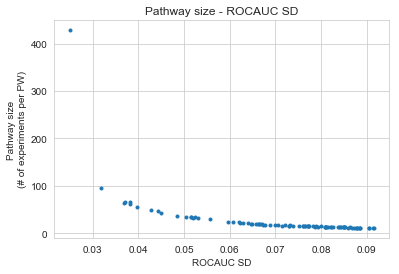

In [284]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Pathway size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Pathway size\n(# of experiments per PW)')

In [285]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/gdsc/single/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/gdsc/single/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/gdsc/single/%s.csv' % method, sep=',')

In [2]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/rocaucs/progeny/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

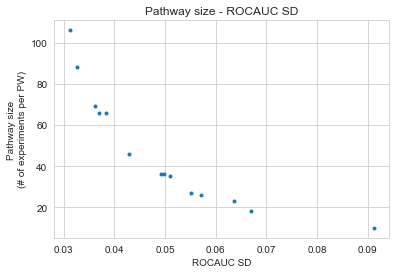

In [3]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Pathway size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Pathway size\n(# of experiments per PW)')

In [4]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/progeny/single/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/progeny/single/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/progeny/single/%s.csv' % method, sep=',')

In [5]:
results=pd.read_csv('../results/benchmark/rocaucs/tcga/random_dist.csv',sep=',',header=0,index_col=0)
tcga=pd.read_csv('../results/benchmark/datasets/tcga_meta.csv',
                        sep=',',header=0,index_col=0)
tcga=tcga['TCGA'].value_counts()
tcga=tcga[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=tcga

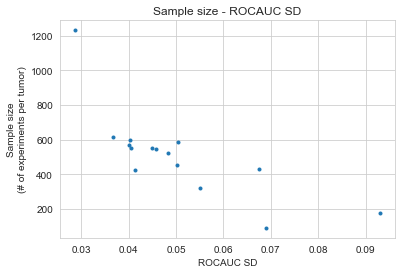

In [6]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Sample size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Sample size\n(# of experiments per tumor)')

In [7]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/tcga/single/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/tcga/single/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/tcga/single/%s.csv' % method, sep=',')

In [3]:
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

In [9]:
dname1='BEST_dorothea_AB'
dname2='KEGG'
abs_type=''
rnd_fil='_filtered'
bname='progeny'
sim_type='jaccard'

In [2]:
def get_correaltions(dname1,dname2,abs_type,rnd_fil,bname,sim_type):
    activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname1,rnd_fil,abs_type),
                     sep=',',header=0,index_col=0).abs().max()
    activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,rnd_fil,abs_type),
                     sep=',',header=0,index_col=0).abs().max()
    if dname1<dname2:
        fname=dname1+rnd_fil+'_'+dname2+rnd_fil+'_'+sim_type+'.csv'
    else:
        fname=dname2+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
    similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
    if dname1<dname2:
        similarity1=similarity.max(1)
        similarity2=similarity.max(0)
    else:
        similarity1=similarity.max(0)
        similarity2=similarity.max(1)
    sets1=list(set(activity1.index)&set(similarity1.index))
    sets2=list(set(activity2.index)&set(similarity2.index))
    activity1=activity1[sets1]
    activity2=activity2[sets2]
    similarity1=similarity1[sets1]
    similarity2=similarity2[sets2]
    return pcor(similarity1,activity1)[0],pcor(similarity2,activity2)[0]

In [5]:
def plot_correaltions(dname1,dname2,abs_type,rnd_fil,bname,sim_type):
    activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname1,rnd_fil,abs_type),
                     sep=',',header=0,index_col=0).abs().max()
    activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,rnd_fil,abs_type),
                     sep=',',header=0,index_col=0).abs().max()
    if dname1<dname2:
        fname=dname1+rnd_fil+'_'+dname2+rnd_fil+'_'+sim_type+'.csv'
    else:
        fname=dname2+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
    similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
    if dname1<dname2:
        similarity1=similarity.max(1)
        similarity2=similarity.max(0)
    else:
        similarity1=similarity.max(0)
        similarity2=similarity.max(1)
    sets1=list(set(activity1.index)&set(similarity1.index))
    sets2=list(set(activity2.index)&set(similarity2.index))
    activity1=activity1[sets1]
    activity2=activity2[sets2]
    similarity1=similarity1[sets1]
    similarity2=similarity2[sets2]
    f,axs=plt.subplots(1,2,figsize=(8,4),dpi=300)
    sns.regplot(similarity1,activity1,ax=axs[0])
    axs[0].set_xlabel('Similarity of %s gene set to %s' % (dname1,dname2))
    axs[0].set_ylabel('Quality of %s gene sets' % dname1)

    sns.regplot(similarity2,activity2,ax=axs[1])
    axs[1].set_xlabel('Similarity of %s gene set to %s' % (dname2,dname1))
    axs[1].set_ylabel('Quality of %s gene sets' % dname2)
    print(pcor(similarity1,activity1))
    print(pcor(similarity2,activity2))
    plt.tight_layout()

In [20]:
results=pd.DataFrame(columns=['data1','data2','r'])
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
abs_type=''
rnd_fil='_filtered'
bname='progeny'
sim_type='jaccard'
for dname1 in datasets:
    for dname2 in datasets:
        if dname1<dname2:
            r1,r2=get_correaltions(dname1,dname2,abs_type,rnd_fil,bname,sim_type)
            temp=pd.DataFrame(index=range(2),columns=results.columns)
            temp.loc[0]=[dname1,dname2,r1]
            temp.loc[1]=[dname2,dname1,r2]
            results=pd.concat([results,temp])
results.index=range(len(results.index)) 
results['r']=results['r'].astype(float)
fil=np.in1d(results['data2'],['BEST_dorothea_AB','CGP'])
results['data_driven_to']=0
results.loc[results.index[fil],'data_driven_to']=1
fil=np.in1d(results['data1'],['BEST_dorothea_AB','CGP'])
results['data_driven_from']=0
results.loc[results.index[fil],'data_driven_from']=1

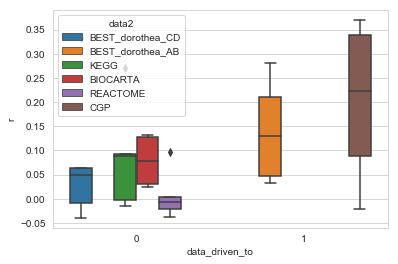

In [21]:
sns.boxplot(y='r',x='data_driven_to',hue='data2',data=results)

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [14]:
model = ols('r ~ data_driven_to',data=results).fit()

In [15]:
model.params

Intercept         0.013367
data_driven_to    0.093521
dtype: float64

In [16]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
data_driven_to,1.0,0.041982,0.041982,4.941032,0.039276
Residual,18.0,0.152939,0.008497,NaN,NaN


/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.0009717657336617389, 0.9919984953439726)
(0.33756957174954433, 3.5835479657153133e-06)


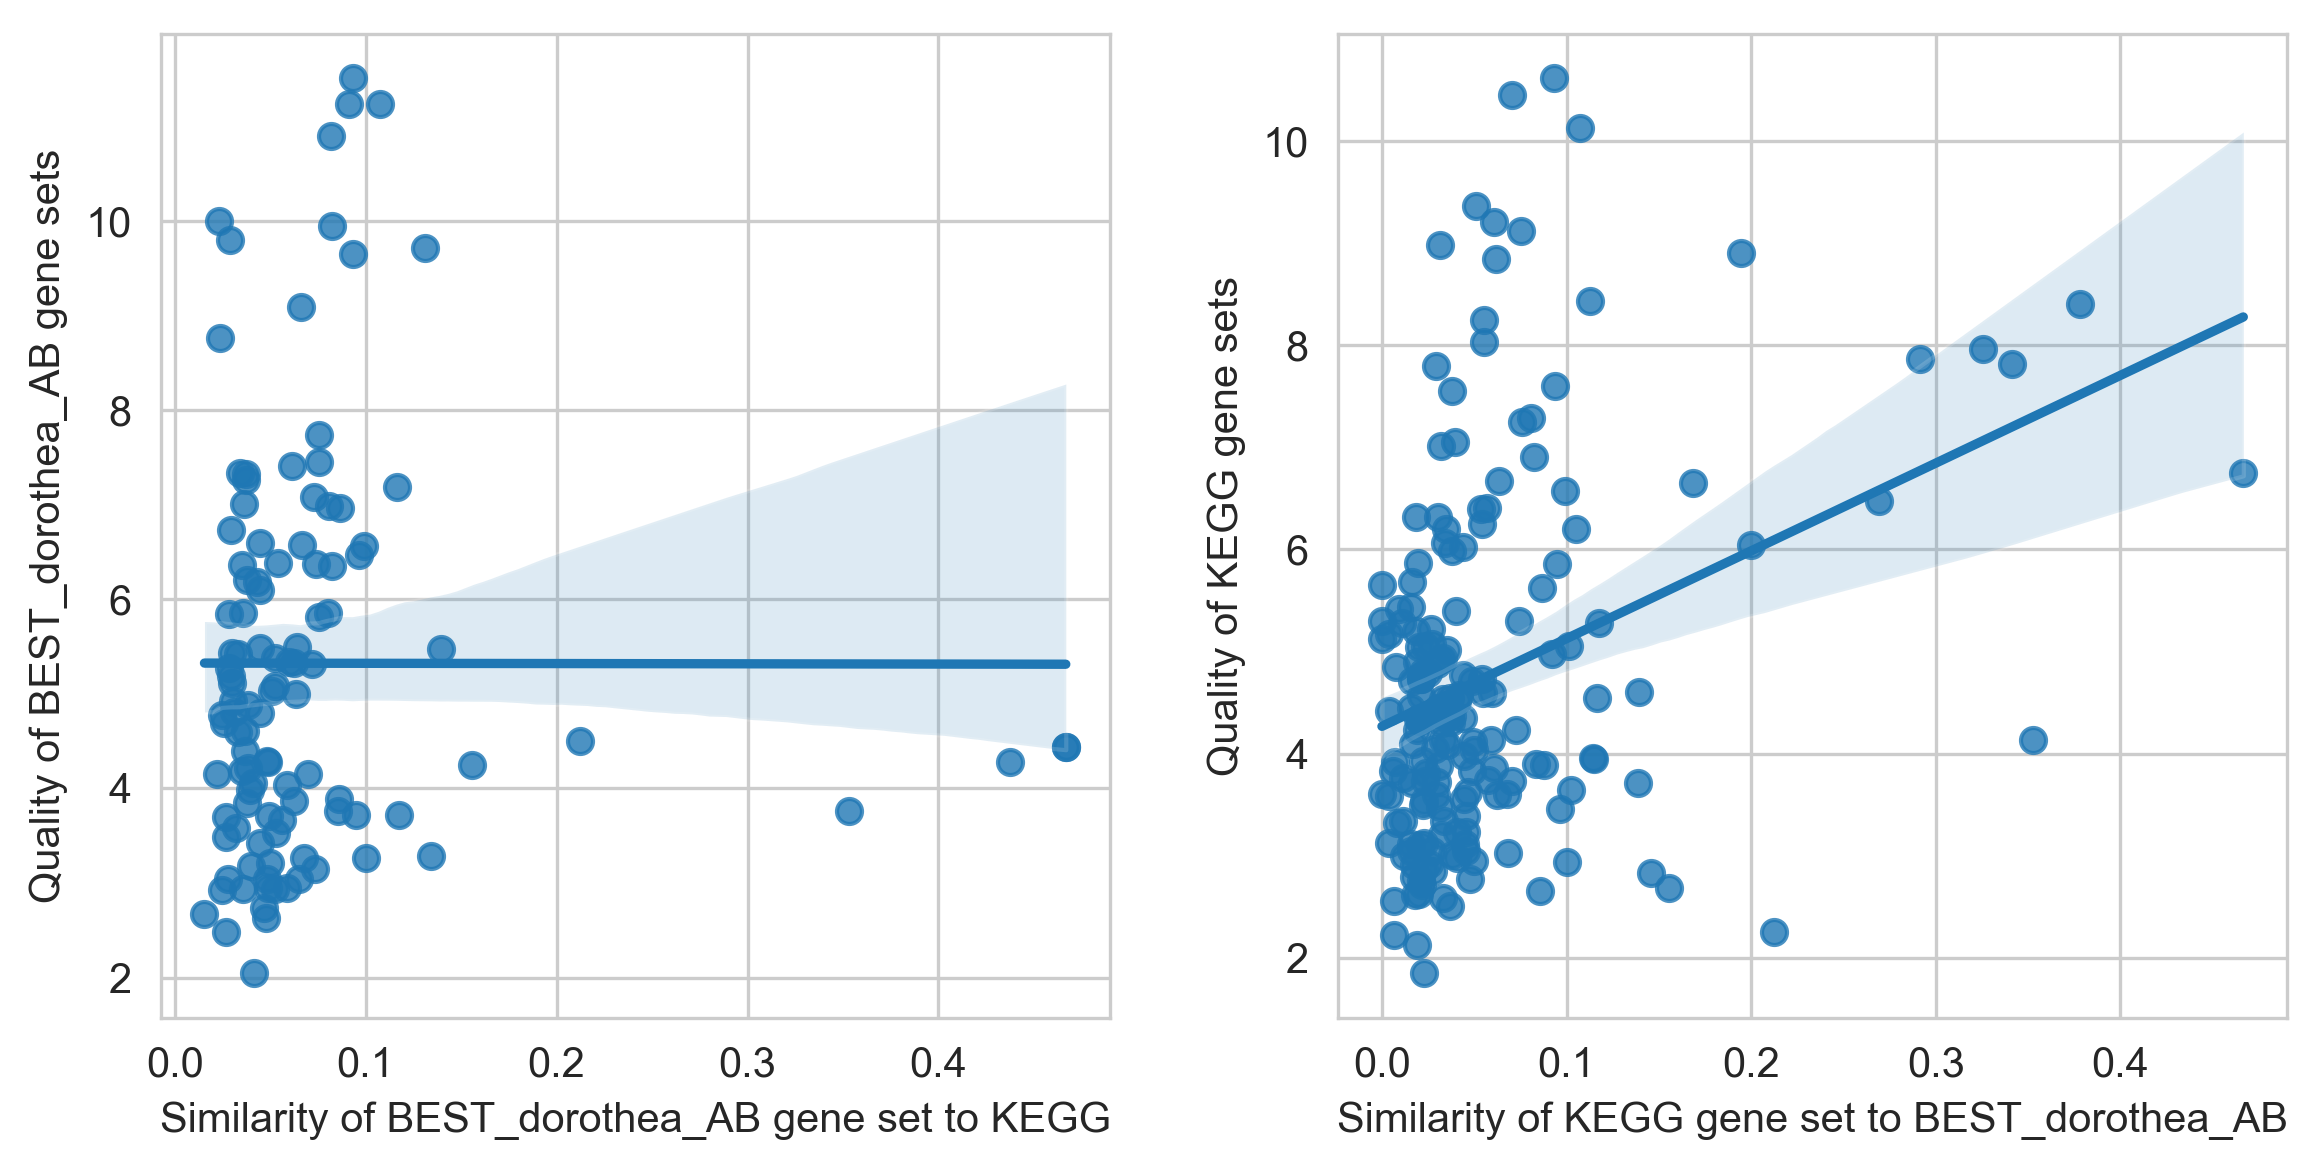

In [6]:
a=plot_correaltions('BEST_dorothea_AB','KEGG','_abs','_filtered','progeny','jaccard')

In [105]:
temp1=pd.read_csv('../results/benchmark/z_scores/tcga/single/BIOCARTA_filtered.csv',sep=',',header=0,index_col=0)

In [141]:
temp=pd.read_csv('../results/benchmark/rocaucs/tcga/random_dist.csv',sep=',',header=0,index_col=0)

In [148]:
temp2=pd.read_csv('../results/benchmark/rocaucs/tcga/single/BIOCARTA_filtered.csv',sep=',',header=0,index_col=0)

(array([22., 42., 59., 37., 58., 28., 12., 16.,  7.,  5.]),
 array([0.09381704, 0.17344468, 0.25307233, 0.33269997, 0.41232761,
        0.49195526, 0.5715829 , 0.65121054, 0.73083819, 0.81046583,
        0.89009347]),
 <a list of 10 Patch objects>)

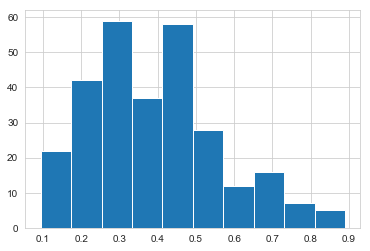

In [149]:
plt.hist(temp2.loc['PRAD'])

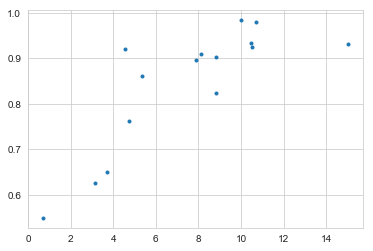

In [112]:
plt.plot(temp1['BIOCARTA_CDC25_PATHWAY'],temp2['BIOCARTA_CDC25_PATHWAY'],'.')

In [114]:
temp2['BIOCARTA_CDC25_PATHWAY']

READ    0.920958
PRAD    0.649556
BRCA    0.932130
LUAD    0.924183
LUSC    0.979494
STAD    0.896461
UCEC    0.910315
COAD    0.983587
BLCA    0.860201
KIRP    0.761961
HNSC    0.903274
KICH    0.549697
LIHC    0.933512
THCA    0.626153
KIRC    0.823596
Name: BIOCARTA_CDC25_PATHWAY, dtype: float64

In [99]:
a[3][a[2].sort_values().index]

BIOCARTA_SM_PATHWAY               12.906923
BIOCARTA_GABA_PATHWAY             12.699717
BIOCARTA_PARKIN_PATHWAY            7.940207
BIOCARTA_RAN_PATHWAY              13.496479
BIOCARTA_PLCE_PATHWAY             13.567358
BIOCARTA_CHREBP_PATHWAY           12.850330
BIOCARTA_ERAD_PATHWAY              7.679399
BIOCARTA_NDKDYNAMIN_PATHWAY        9.489173
BIOCARTA_ARAP_PATHWAY             10.940177
BIOCARTA_EIF_PATHWAY               7.960824
BIOCARTA_AMAN_PATHWAY              8.566707
BIOCARTA_BARR_MAPK_PATHWAY        13.425326
BIOCARTA_COMP_PATHWAY             11.523782
BIOCARTA_CLASSIC_PATHWAY          11.351437
BIOCARTA_PRC2_PATHWAY             13.883840
BIOCARTA_ERK5_PATHWAY              9.641931
BIOCARTA_LECTIN_PATHWAY           13.088240
BIOCARTA_BIOPEPTIDES_PATHWAY       9.812461
BIOCARTA_RACC_PATHWAY             10.743296
BIOCARTA_BARRESTIN_PATHWAY        13.424502
BIOCARTA_NOS1_PATHWAY             12.878626
BIOCARTA_VDR_PATHWAY               7.778659
BIOCARTA_PS1_PATHWAY            

In [ ]:
f,axs=plt.subplots(1,2,figsize=(8,4),dpi=300)
sns.regplot(similarity1,activity1,ax=axs[0])
axs[0].set_xlabel('Similarity of %s gene set to %s' % (dname1,dname2))
axs[0].set_ylabel('Quality of %s gene sets' % dname1)

sns.regplot(similarity2,activity2,ax=axs[1])
axs[1].set_xlabel('Similarity of %s gene set to %s' % (dname2,dname1))
axs[1].set_ylabel('Quality of %s gene sets' % dname2)
print(pcor(similarity1,activity1))
print(pcor(similarity2,activity2))
plt.tight_layout()

In [25]:
temp=pd.read_csv('../results/benchmark/z_scores/tcga/single/BIOCARTA_filtered.csv',sep=',',header=0,index_col=0)

In [28]:
temp.abs().max().sort_values()

BIOCARTA_CARM_ER_PATHWAY            5.145952
BIOCARTA_MTOR_PATHWAY               5.727395
BIOCARTA_BCELLSURVIVAL_PATHWAY      5.986079
BIOCARTA_TERC_PATHWAY               6.039092
BIOCARTA_CTBP1_PATHWAY              6.086637
BIOCARTA_RAC1_PATHWAY               6.126049
BIOCARTA_PITX2_PATHWAY              6.429380
BIOCARTA_IGF1MTOR_PATHWAY           7.125498
BIOCARTA_HSWI_SNF_PATHWAY           7.279951
BIOCARTA_P53HYPOXIA_PATHWAY         7.348252
BIOCARTA_SARS_PATHWAY               7.364376
BIOCARTA_SALMONELLA_PATHWAY         7.409513
BIOCARTA_AKAPCENTROSOME_PATHWAY     7.577318
BIOCARTA_PELP1_PATHWAY              7.600469
BIOCARTA_ERAD_PATHWAY               7.679399
BIOCARTA_SLRP_PATHWAY               7.712757
BIOCARTA_VDR_PATHWAY                7.778659
BIOCARTA_TEL_PATHWAY                7.804200
BIOCARTA_TFF_PATHWAY                7.851993
BIOCARTA_RECK_PATHWAY               7.892661
BIOCARTA_CREM_PATHWAY               7.925637
BIOCARTA_PARKIN_PATHWAY             7.940207
BIOCARTA_E

Index(['BIOCARTA_41BB_PATHWAY', 'BIOCARTA_ACE2_PATHWAY',
       'BIOCARTA_ACETAMINOPHEN_PATHWAY', 'BIOCARTA_ACH_PATHWAY',
       'BIOCARTA_ACTINY_PATHWAY', 'BIOCARTA_AGPCR_PATHWAY',
       'BIOCARTA_AGR_PATHWAY', 'BIOCARTA_AHSP_PATHWAY',
       'BIOCARTA_AKAP13_PATHWAY', 'BIOCARTA_AKAP95_PATHWAY',
       ...
       'BIOCARTA_TSP1_PATHWAY', 'BIOCARTA_TUBBY_PATHWAY',
       'BIOCARTA_UCALPAIN_PATHWAY', 'BIOCARTA_VDR_PATHWAY',
       'BIOCARTA_VEGF_PATHWAY', 'BIOCARTA_VIP_PATHWAY',
       'BIOCARTA_VITCB_PATHWAY', 'BIOCARTA_VOBESITY_PATHWAY',
       'BIOCARTA_WNT_LRP6_PATHWAY', 'BIOCARTA_WNT_PATHWAY'],
      dtype='object', length=286)

In [ ]:
def plot_similarity_and_quality(dname1,dname2,bname='progeny',sim_type='jaccard',abs_type=False,size_fil=False):
    sns.set_palette('GnBu',3)
    if abs_type:
        activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_abs.csv' % (bname,dname1),
                              sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_abs.csv' % (bname,dname2),
                              sep=',',header=0,index_col=0).abs().max()
    else:
        activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s.csv' % (bname,dname1),
                              sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s.csv' % (bname,dname2),
                              sep=',',header=0,index_col=0).abs().max()
    if dname1<dname2:
        simname=dname1+'_'+dname2
    else:
        simname=dname2+'_'+dname1
    if sim_type=='jaccard':
        similarity=pd.read_csv('../results/similarity/%s_jaccard.csv' % simname,sep=',',header=0,index_col=0)
        if size_fil:
            size1=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname1,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size2=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname2,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size1=size1[size1<size_fil].index
            size2=size2[size2<size_fil].index
        else:
            size1=activity1.index
            size2=activity2.index
        if dname1<dname2:
            similarity1=similarity.loc[size1,size2].max(1)
            similarity2=similarity.loc[size1,size2].max(0)
        else:
            similarity1=similarity.loc[size2,size1].max(0)
            similarity2=similarity.loc[size2,size1].max(1)
    elif sim_type=='overlap':
        similarity=pd.read_csv('../results/similarity/%s_overlap.csv' % simname,sep=',',header=0,index_col=0)
        if size_fil:
            size1=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname1,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size2=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname2,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size1=size1[size1<size_fil].index
            size2=size2[size2<size_fil].index
        else:
            size1=activity1.index
            size2=activity2.index
        if dname1<dname2:
            similarity1=similarity.loc[size1,size2].max(1)
            similarity2=similarity.loc[size1,size2].max(0)
        else:
            similarity1=similarity.loc[size2,size1].max(0)
            similarity2=similarity.loc[size2,size1].max(1)
    else:
        similarity1=pd.read_csv('../results/similarity/%s_first.csv' % simname,sep=',',header=0,index_col=0)
        similarity2=pd.read_csv('../results/similarity/%s_second.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity1.max(1)
            similarity2=similarity2.max(0)
        else:
            temp1=similarity2.max(0)
            temp2=similarity1.max(1)
            similarity1=temp1
            similarity2=temp2
    common1=list(set(similarity1.index)&set(activity1.index));similarity1=similarity1[common1];activity1=activity1[common1]
    common2=list(set(similarity2.index)&set(activity2.index));similarity2=similarity2[common2];activity2=activity2[common2]
    if dname1=='dorothea_AB':
        dname1='DoRothEA'
    if dname2=='dorothea_AB':
        dname2='DoRothEA'
    f,axs=plt.subplots(1,2,figsize=(8,4),dpi=300)
    sns.regplot(similarity1[common1],activity1[common1],ax=axs[0])
    axs[0].set_xlabel('Similarity of %s gene set to %s' % (dname1,dname2))
    axs[0].set_ylabel('Quality of %s gene sets' % dname1)

    sns.regplot(similarity2[common2],activity2[common2],ax=axs[1])
    axs[1].set_xlabel('Similarity of %s gene set to %s' % (dname2,dname1))
    axs[1].set_ylabel('Quality of %s gene sets' % dname2)
    print(pcor(similarity1[common1],activity1[common1]))
    print(pcor(similarity2[common2],activity2[common2]))
    plt.tight_layout()

In [ ]:
plot_similarity_and_quality('dorothea_AB','BIOCARTA','progeny',sim_type='jaccard',abs_type=True,size_fil=False)
plt.savefig('proba.pdf')

In [ ]:
def calclate_similarity_and_quality(dname1,dname2,bname='progeny',sim_type='jaccard',abs_type=False,size_fil=False):
    if abs_type:
        activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_abs.csv' % (bname,dname1),
                              sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_abs.csv' % (bname,dname2),
                              sep=',',header=0,index_col=0).abs().max()
    else:
        activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s.csv' % (bname,dname1),
                              sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s.csv' % (bname,dname2),
                              sep=',',header=0,index_col=0).abs().max()
    if dname1<dname2:
        simname=dname1+'_'+dname2
    else:
        simname=dname2+'_'+dname1
    if sim_type=='jaccard':
        similarity=pd.read_csv('../results/similarity/%s_jaccard.csv' % simname,sep=',',header=0,index_col=0)
        if size_fil:
            size1=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname1,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size2=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname2,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size1=size1[size1<size_fil].index
            size2=size2[size2<size_fil].index
        else:
            size1=activity1.index
            size2=activity2.index
        if dname1<dname2:
            similarity1=similarity.loc[size1,size2].max(1)
            similarity2=similarity.loc[size1,size2].max(0)
        else:
            similarity1=similarity.loc[size2,size1].max(0)
            similarity2=similarity.loc[size2,size1].max(1)
    elif sim_type=='overlap':
        similarity=pd.read_csv('../results/similarity/%s_overlap.csv' % simname,sep=',',header=0,index_col=0)
        if size_fil:
            size1=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname1,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size2=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname2,
                              sep=',',header=0,index_col=0)['Set'].value_counts()
            size1=size1[size1<size_fil].index
            size2=size2[size2<size_fil].index
        else:
            size1=activity1.index
            size2=activity2.index
        if dname1<dname2:
            similarity1=similarity.loc[size1,size2].max(1)
            similarity2=similarity.loc[size1,size2].max(0)
        else:
            similarity1=similarity.loc[size2,size1].max(0)
            similarity2=similarity.loc[size2,size1].max(1)
    else:
        similarity1=pd.read_csv('../results/similarity/%s_first.csv' % simname,sep=',',header=0,index_col=0)
        similarity2=pd.read_csv('../results/similarity/%s_second.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity1.max(1)
            similarity2=similarity2.max(0)
        else:
            temp1=similarity2.max(0)
            temp2=similarity1.max(1)
            similarity1=temp1
            similarity2=temp2
    common1=list(set(similarity1.index)&set(activity1.index));similarity1=similarity1[common1];activity1=activity1[common1]
    common2=list(set(similarity2.index)&set(activity2.index));similarity2=similarity2[common2];activity2=activity2[common2]
    r1=pcor(similarity1[common1],activity1[common1])[0]
    r2=pcor(similarity2[common2],activity2[common2])[0]
    
    return r1,r2

In [ ]:
setnames=['dorothea_AB','CGP','BIOCARTA','KEGG','REACTOME']
results=pd.DataFrame(0.0,index=setnames,columns=setnames)
for dname1 in setnames:
    for dname2 in setnames:
        if dname1!=dname2:
            r1,r2=calclate_similarity_and_quality(dname1,dname2,'progeny','jaccard',True,False)
            results.loc[dname1,dname2]=r1
setnames=['DoRothEA','CGP','BIOCARTA','KEGG','REACTOME']
results.columns=setnames; results.index=setnames;

In [ ]:
results['similarity_of']=results.index
results=results.melt(id_vars=['similarity_of'],value_vars=results.columns[:-1])
results.columns=['similarity_of','similarity_to','correlation']
fil=results['correlation']!=0
results=results[fil]

In [ ]:
plt.figure(figsize=(4,4),dpi=300)
sns.set_palette('GnBu',5)
sns.boxplot(x='similarity_to',y='correlation',data=results)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Similarity to',size=9)
plt.ylabel('Correlation between similarity and quality',size=9)
plt.savefig('proba.pdf')

In [ ]:
results['data_driven']=0
fil=np.in1d(results['similarity_to'],['DoRothEA','CGP']); indexes=results.index[fil];
results.loc[indexes,'data_driven']=1

In [ ]:
results